# Notebook to anakyse the CellPainting datasets 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from matplotlib.colors import to_hex

In [27]:
# Load data
df_level5 = pd.read_csv("../02_processed_data/df_level5.csv")

In [28]:
# Define important arguments
meta_features = df_level5.columns[df_level5.columns.str.startswith("Metadata_")].to_list()
features = df_level5.drop(meta_features, axis="columns").columns.tolist()

In [34]:
# Load mAP
df_map = pd.read_csv("../02_processed_data/mean_average_precision.csv")
df_map["-log10(p-value)"] = -df_map["corrected_p_value"].apply(np.log10)

In [36]:
# merge dt_level5 and map
df_level5_map = pd.merge(
    df_level5,
    df_map,
    on=["Metadata_JCP2022"],
    how="left"   # or "left", "right", "outer" depending on what you need
)

# Profiles analysis
## Heatmap of profiles colored by chanels with and without grouping

/var/folders/lc/7wdpn93n1lxb3jkq1r02d6yw0000gp/T/ipykernel_11732/65734750.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_pval = cm.get_cmap("YlOrRd")  # yellow to red color gradient
/Users/ollitrault/Documents/projects/2025_CellPainting_Training/.env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


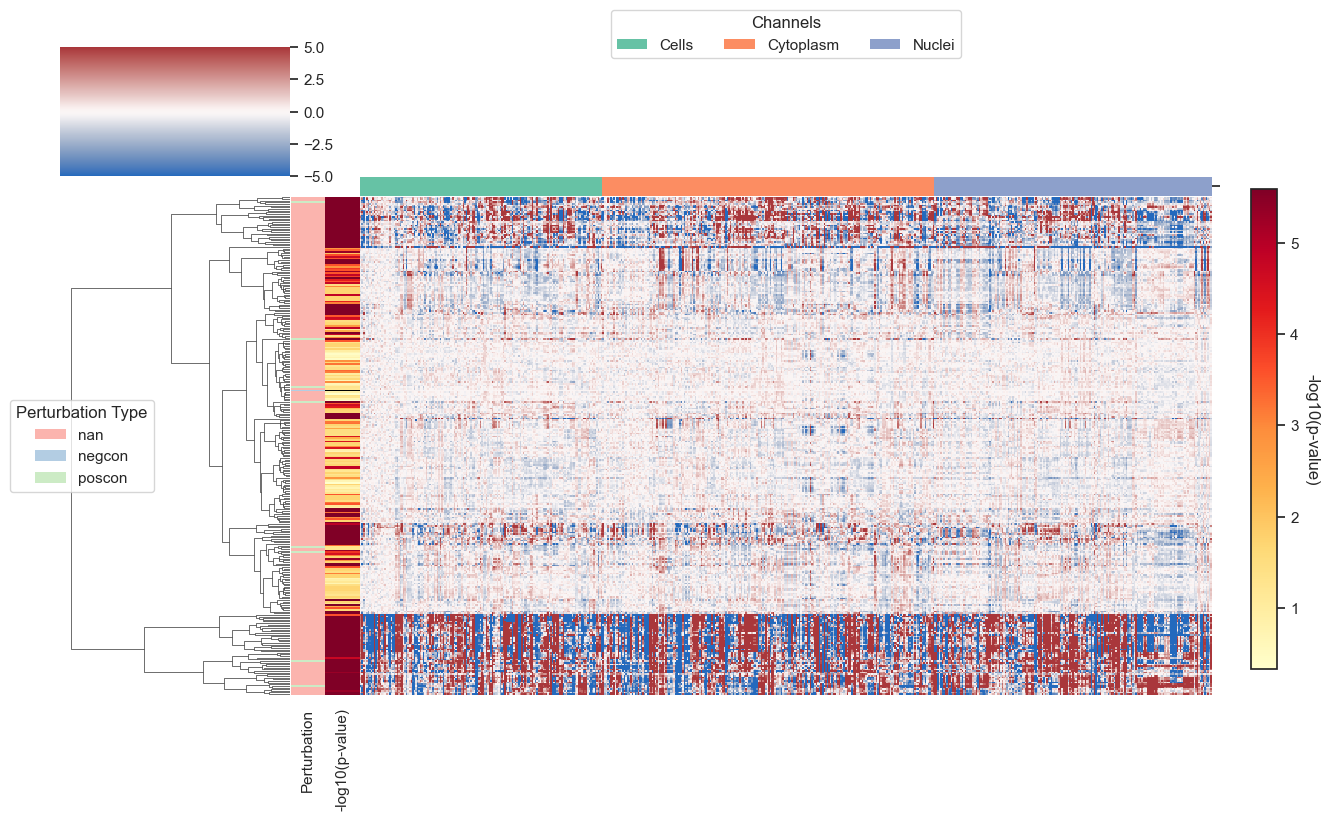

In [59]:
# --- Extract the feature matrix ---
feature_data = df_level5_map[features]

# --- Extract channel info from feature names ---
channels = [f.split("_")[0] if "_" in f else "Unknown" for f in features]

# --- Channel color palette ---
unique_channels = sorted(set(channels))
palette = sns.color_palette("Set2", len(unique_channels))
channel_colors = dict(zip(unique_channels, palette))
col_colors = pd.Series(channels, index=features).map(channel_colors)

# --- Clip data range ---
feature_data_clipped = feature_data.clip(lower=-5, upper=5)

# --- Left annotation: Perturbation type ---
pert_types = df_level5_map["Metadata_pert_type"].astype(str)
unique_pert_types = sorted(pert_types.unique())
palette_perts = sns.color_palette("Pastel1", len(unique_pert_types))
pert_colors = dict(zip(unique_pert_types, palette_perts))
row_colors = pert_types.map(pert_colors)

# --- Right annotation: -log10(p-value) ---
pvals = df_level5_map["-log10(p-value)"]
norm = Normalize(vmin=pvals.min(), vmax=pvals.max())
cmap_pval = cm.get_cmap("YlOrRd")  # yellow to red color gradient
pval_colors = [cmap_pval(norm(v)) for v in pvals]

# Combine both left and right row annotations
# Seaborn only supports ONE row color DataFrame, so we merge them side by side
row_colors_combined = pd.DataFrame({
    "Perturbation": row_colors,
    "-log10(p-value)": pval_colors
}, index=df_level5_map.index)

# --- Create clustermap ---
sns.set(style="white")
g = sns.clustermap(
    feature_data_clipped,
    cmap="vlag",
    col_colors=col_colors,
    row_colors=row_colors_combined,
    xticklabels=False,
    yticklabels=False,
    figsize=(13, 8),
    center=0,
    vmin=-5,
    vmax=5,
    col_cluster=False,
    method='ward'
)

# --- Add legends ---
# Channels legend (top)
for label in unique_channels:
    g.ax_col_dendrogram.bar(0, 0, color=channel_colors[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(
    title="Channels",
    loc="center",
    ncol=len(unique_channels),
    bbox_to_anchor=(0.5, 1.1)
)

# Perturbation type legend (left)
for label in unique_pert_types:
    g.ax_row_dendrogram.bar(0, 0, color=pert_colors[label], label=label, linewidth=0)
g.ax_row_dendrogram.legend(
    title="Perturbation Type",
    loc="center left",
    bbox_to_anchor=(-0.25, 0.5)
)

# --- Add colorbar for -log10(p-value) ---
sm = plt.cm.ScalarMappable(cmap=cmap_pval, norm=norm)
sm.set_array([])

# Instead of attaching directly to ax_heatmap,
# use the figure's add_axes() to manually position it
# [left, bottom, width, height] — relative to figure size
cbar_ax = g.fig.add_axes([0.93, 0.2, 0.02, 0.6])
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("-log10(p-value)", rotation=270, labelpad=15)

# --- Adjust layout ---
g.fig.subplots_adjust(right=0.9)  # leave room for colorbar

plt.show()

# chemical visualisation umap colored by mAP

In [62]:
import umap
import matplotlib.pyplot as plt

# --- Prepare data ---
# Clip or standardize features to improve embedding quality
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(feature_data)

# --- Run UMAP ---
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
embedding = reducer.fit_transform(X_scaled)


/Users/ollitrault/Documents/projects/2025_CellPainting_Training/.env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


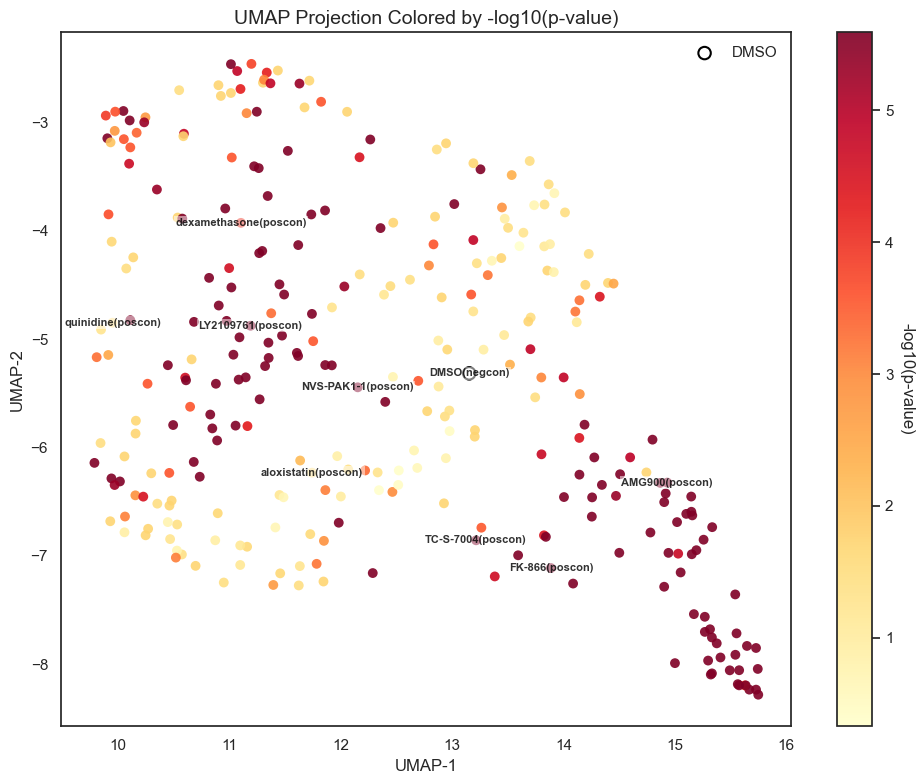

In [88]:
# --- Prepare coloring ---
pvals = df_level5_map["-log10(p-value)"]
norm = plt.Normalize(vmin=pvals.min(), vmax=pvals.max())
cmap = plt.cm.YlOrRd

# --- Plot UMAP ---
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=pvals,
    cmap=cmap,
    norm=norm,
    s=50,
    edgecolor="none",
    alpha=0.9
)
plt.title("UMAP Projection Colored by -log10(p-value)", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# --- Add colorbar ---
cbar = plt.colorbar(sc)
cbar.set_label("-log10(p-value)", rotation=270, labelpad=15)

# --- Highlight and label DMSO points ---
dmso_mask = df_level5_map["Metadata_Name"] == "DMSO"
plt.scatter(
    embedding[dmso_mask, 0],
    embedding[dmso_mask, 1],
    color="none",
    s=80,
    edgecolor="black",
    linewidth=1.5,
    label="DMSO"
)

# --- Label samples with non-null Metadata_pert_type ---
valid_mask = df_level5_map["Metadata_pert_type"].notna()
for i in np.where(valid_mask)[0]:
    label = str(df_level5_map.loc[i, "Metadata_Name"]) + '(' + str(df_level5_map.loc[i, "Metadata_pert_type"]) + ')'
    plt.text(
        embedding[i, 0],
        embedding[i, 1],
        label,
        fontsize=8,
        color="black",
        ha="center",
        va="center",
        weight="semibold",
        alpha=0.8,
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=1)
    )

# --- Add legend ---
plt.legend(frameon=False, loc="best")

plt.tight_layout()
plt.show()
